# 02 - Creating Synthetic Regional Clusters

## Ziel
Erstelle synthetische regionale Cluster aus SOEP-Daten und verknüpfe sie mit echten INKAR-Regionaldaten.

## Datenquellen
- **SOEP:** Sozio-oekonomisches Panel (Individualdaten, 2015-2019)
- **INKAR:** Indikatoren und Karten zur Raum- und Stadtentwicklung (2015-2019)

## Methodik
1. K-Means Clustering → 16 synthetische Cluster
2. Hungarian Algorithm → Optimale 1:1 Zuordnung zu Bundesländern
3. Jahr-spezifischer Merge → SOEP-Jahr = INKAR-Jahr
4. Qualitätskontrolle → Bewertung der Match-Qualität

---
## Imports

In [1]:
# Pandas für Datenmanipulation
import pandas as pd

# NumPy für numerische Berechnungen
import numpy as np

# Matplotlib für Plots
import matplotlib.pyplot as plt

# Seaborn für statistische Visualisierungen
import seaborn as sns

# Path für Dateipfad-Handling
from pathlib import Path

# sys für Python-Suchpfad
import sys

# re für Regular Expressions (String-Parsing)
import re

# Füge Parent-Directory zum Suchpfad hinzu
sys.path.append('../')

# Importiere Clustering-Klasse
from src.regional_mapper import RegionalClusterMapper

# Importiere INKAR-Funktionen
from src.regional_mapper import create_inkar_long_format
from src.regional_mapper import create_inkar_averaged

# Importiere Matching-Funktionen
from src.regional_mapper import match_clusters_to_bundeslaender
from src.regional_mapper import merge_inkar_by_year
from src.regional_mapper import print_matching_report

# Setze Plot-Style
plt.style.use('seaborn-v0_8-whitegrid')

# Setze Farbpalette
sns.set_palette('Set2')

# Zeige alle Spalten
pd.set_option('display.max_columns', None)

# Plots inline im Notebook
%matplotlib inline

---
## 1. Daten laden

In [2]:
# Pfad zur bereinigten CSV
data_path = '../data/processed/soep_cleaned.csv'

# Prüfe ob Datei existiert
if not Path(data_path).exists():
    # Fehlermeldung
    print('FEHLER: Daten nicht gefunden!')
    print('Bitte zuerst 01_data_exploration.ipynb ausführen.')
else:
    # Lade CSV
    df = pd.read_csv(data_path)
    # Zeige Info
    print(f'Geladen: {len(df)} Zeilen, {len(df.columns)} Spalten')
    print(f'Spalten: {df.columns.tolist()}')

Geladen: 21753 Zeilen, 16 Spalten
Spalten: ['id', 'syear', 'sex', 'alter', 'anz_pers', 'anz_kind', 'bildung', 'erwerb', 'branche', 'gesund_org', 'lebensz_org', 'einkommenj1', 'einkommenj2', 'einkommenm1', 'einkommenm2', 'high_education']


In [3]:
# Prüfe syear-Spalte (Jahr)
if 'syear' in df.columns:
    # Zeige Jahr-Verteilung
    print('Jahr-Verteilung (syear):')
    print(df['syear'].value_counts().sort_index())
else:
    # Warnung
    print('WARNUNG: syear-Spalte nicht gefunden!')

Jahr-Verteilung (syear):
syear
2015.0    5141
2016.0    4611
2017.0    4356
2018.0    4010
2019.0    3635
Name: count, dtype: int64


---
## 1b. Datenbereinigung: String-Labels konvertieren

SOEP-Daten enthalten manchmal String-Labels wie `'[4] Not so well'` statt numerischer Werte.  
Diese Zelle extrahiert die Zahlen automatisch.

In [4]:
def extract_numeric_from_label(value):
    """
    Extrahiert numerischen Wert aus String-Label
    
    Beispiele:
    '[4] Not so well' -> 4.0
    '7.0' -> 7.0
    7 -> 7.0
    NaN -> NaN
    """
    # Wenn bereits numerisch, gib zurück
    if pd.isna(value) or isinstance(value, (int, float)):
        return value
    
    # Konvertiere zu String
    value_str = str(value)
    
    # Suche nach Zahl am Anfang (z.B. '[4]' in '[4] Not so well')
    match = re.search(r'\[(\d+)\]', value_str)
    if match:
        # Gib erste Gruppe zurück (die Zahl)
        return float(match.group(1))
    
    # Falls kein Label, versuche direkte Konvertierung
    try:
        return float(value_str)
    except ValueError:
        # Wenn nichts funktioniert, gib NaN zurück
        return np.nan

# Liste der Spalten die möglicherweise String-Labels haben
label_columns = ['gesund_org', 'lebensz_org']

# Konvertiere jede Spalte
for col in label_columns:
    # Prüfe ob Spalte existiert
    if col in df.columns:
        # Zeige Original-Typ
        print(f'\nKonvertiere {col}...')
        print(f'  Original-Typ: {df[col].dtype}')
        print(f'  Beispiel vorher: {df[col].iloc[0]}')
        
        # Wende Konvertierung an
        df[col] = df[col].apply(extract_numeric_from_label)
        
        # Zeige neuen Typ
        print(f'  Neuer Typ: {df[col].dtype}')
        print(f'  Beispiel nachher: {df[col].iloc[0]}')

print('\nString-Label Konvertierung abgeschlossen')


Konvertiere gesund_org...
  Original-Typ: object
  Beispiel vorher: [4] Not so well 
  Neuer Typ: float64
  Beispiel nachher: 4.0

Konvertiere lebensz_org...
  Original-Typ: object
  Beispiel vorher: 6.0
  Neuer Typ: float64
  Beispiel nachher: 6.0

String-Label Konvertierung abgeschlossen


In [5]:
# Zeige erste Zeilen nach Konvertierung
df.head()

,id,syear,sex,alter,anz_pers,anz_kind,bildung,erwerb,branche,gesund_org,lebensz_org,einkommenj1,einkommenj2,einkommenm1,einkommenm2,high_education
0,194.0,2015.0,[1] female,59.0,2.0,0.0,10.5,[-2] Employed part-time,[84] Public administration and defense; compul...,4.0,6.0,28678.943359,0.0,1659.128540,0.0,0
1,194.0,2016.0,[1] female,60.0,2.0,0.0,10.5,[-2] Employed part-time,[84] Public administration and defense; compul...,3.0,5.0,19962.292969,0.0,1809.336426,0.0,0
2,194.0,2017.0,[1] female,61.0,2.0,0.0,10.5,[-2] Employed part-time,[84] Public administration and defense; compul...,3.0,7.0,22227.675781,0.0,1849.037476,0.0,0
3,194.0,2018.0,[1] female,62.0,2.0,0.0,10.5,[-2] Employed part-time,[84] Public administration and defense; compul...,5.0,5.0,22100.378906,0.0,1616.513672,0.0,0
4,194.0,2019.0,[1] female,63.0,2.0,0.0,10.5,[-2] Employed part-time,[84] Public administration and defense; compul...,4.0,6.0,23157.919922,0.0,1901.001221,0.0,0


---
## 2. Features für Clustering

In [6]:
# Liste der Clustering-Features
clustering_features = [
    'einkommenj1',      # Jahreseinkommen
    'bildung',          # Bildungsjahre
    'anz_kind',         # Anzahl Kinder
    'anz_pers',         # Haushaltsgröße
    'gesund_org',       # Gesundheit
    'lebensz_org'       # Lebenszufriedenheit
]

# Filtere nur vorhandene Features
available_features = [f for f in clustering_features if f in df.columns]

# Zeige verfügbare Features
print(f'Verfügbare Features: {len(available_features)}')
for f in available_features:
    print(f'  - {f}')

Verfügbare Features: 6
  - einkommenj1
  - bildung
  - anz_kind
  - anz_pers
  - gesund_org
  - lebensz_org


In [7]:
# Prüfe fehlende Werte
print('Fehlende Werte:')
missing = df[available_features].isnull().sum()
print(missing)

# Prüfe Datentypen
print('\nDatentypen:')
print(df[available_features].dtypes)

Fehlende Werte:
einkommenj1      0
bildung          0
anz_kind        59
anz_pers        59
gesund_org      83
lebensz_org    112
dtype: int64

Datentypen:
einkommenj1    float64
bildung        float64
anz_kind       float64
anz_pers       float64
gesund_org     float64
lebensz_org    float64
dtype: object


---
## 3. Elbow Method

In [8]:
# Importiere KMeans
from sklearn.cluster import KMeans

# Importiere StandardScaler
from sklearn.preprocessing import StandardScaler

# Kopiere Features
X = df[available_features].copy()

# Fülle NaN mit Median
X = X.fillna(X.median())

# WICHTIG: Konvertiere zu numerisch (falls noch nicht)
X = X.apply(pd.to_numeric, errors='coerce')

# Fülle eventuelle neue NaN (durch coerce) mit Median
X = X.fillna(X.median())

# Erstelle Scaler
scaler = StandardScaler()

# Standardisiere
X_scaled = scaler.fit_transform(X)

# Info
print(f'Standardisierte Daten: {X_scaled.shape}')

Standardisierte Daten: (21753, 6)


In [9]:
# Liste für Inertia-Werte
inertias = []

# Teste k von 2 bis 24
K_range = range(2, 25)

# Info
print('Teste Cluster-Anzahlen...')

# Iteriere durch k-Werte
for k in K_range:
    # Erstelle KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    # Trainiere
    kmeans.fit(X_scaled)
    # Speichere Inertia
    inertias.append(kmeans.inertia_)
    # Fortschritt
    if k % 5 == 0:
        print(f'  k={k}')

# Fertig
print('Fertig')

Teste Cluster-Anzahlen...
  k=5
  k=10
  k=15
  k=20
Fertig


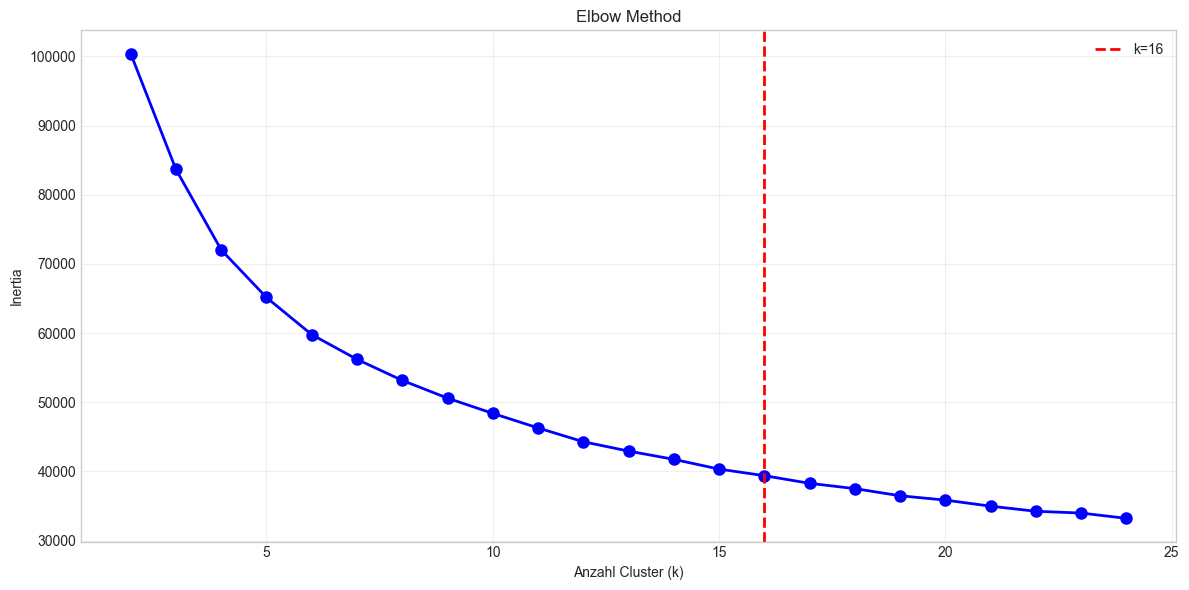

In [10]:
# Erstelle Figure
fig, ax = plt.subplots(figsize=(12, 6))

# Zeichne Kurve
ax.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)

# Markiere k=16
ax.axvline(x=16, color='red', linestyle='--', linewidth=2, label='k=16')

# Labels
ax.set_xlabel('Anzahl Cluster (k)')
ax.set_ylabel('Inertia')
ax.set_title('Elbow Method')

# Grid und Legende
ax.grid(True, alpha=0.3)
ax.legend()

# Layout
plt.tight_layout()
plt.show()

---
## 4. Cluster erstellen

In [11]:
# Erstelle Mapper mit 16 Clustern
mapper = RegionalClusterMapper(n_clusters=16, random_state=42)

# Führe Clustering durch
df = mapper.create_clusters(df, available_features)


Erstelle 16 synthetische Cluster...
Features: ['einkommenj1', 'bildung', 'anz_kind', 'anz_pers', 'gesund_org', 'lebensz_org']
Erstellt: 16 Cluster

Cluster-Verteilung:
region_cluster
0     1350
1     2346
2     1741
3     1025
4      545
5     1216
6     1093
7     1669
8      453
9     1567
10    1692
11    1338
12    1080
13    1962
14    1480
15    1196
Name: count, dtype: int64


Cluster-Größen:
region_cluster
0     1350
1     2346
2     1741
3     1025
4      545
5     1216
6     1093
7     1669
8      453
9     1567
10    1692
11    1338
12    1080
13    1962
14    1480
15    1196
Name: count, dtype: int64


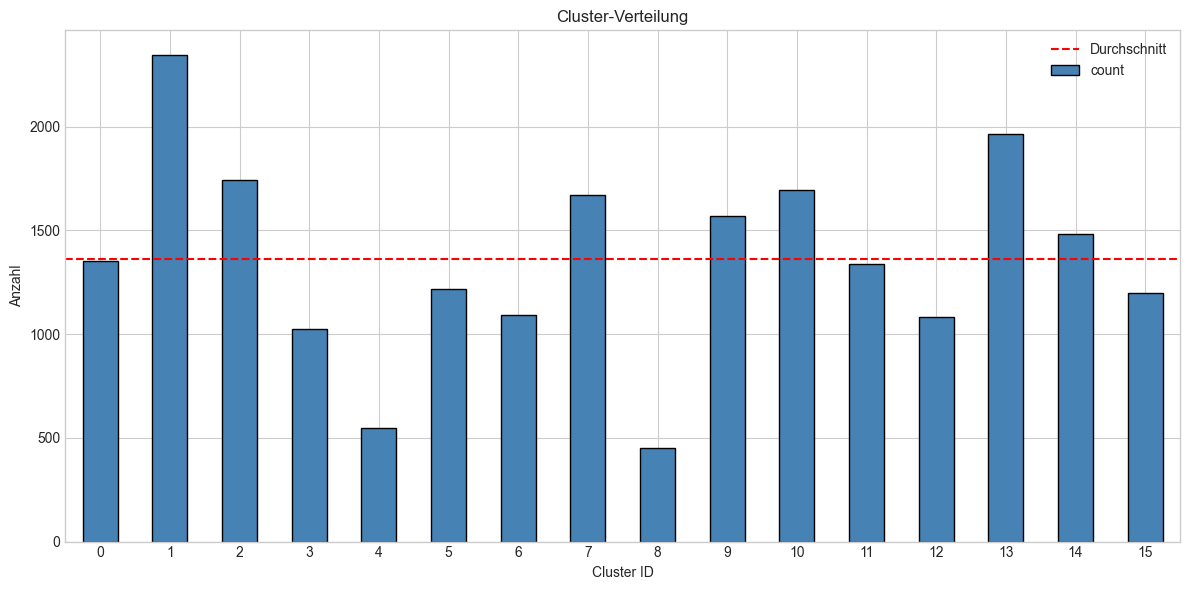

In [12]:
# Zeige Cluster-Größen
print('Cluster-Größen:')
cluster_counts = df['region_cluster'].value_counts().sort_index()
print(cluster_counts)

# Visualisiere
fig, ax = plt.subplots(figsize=(12, 6))

# Balkendiagramm
cluster_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')

# Labels
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Anzahl')
ax.set_title('Cluster-Verteilung')

# Durchschnittslinie
ax.axhline(y=len(df)/16, color='red', linestyle='--', label='Durchschnitt')
ax.legend()

# Layout
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

---
## 5. Cluster-Profile

In [13]:
# Bestimme Profile-Variablen
if 'high_education' in df.columns:
    profile_vars = available_features + ['high_education']
else:
    profile_vars = available_features

# Erstelle Profile
cluster_profiles = mapper.profile_clusters(df, profile_vars)

# Zeige Profile
print('\nCluster-Profile:')
cluster_profiles.round(2)


Erstelle Cluster-Profile...
Cluster-Profile erstellt

Cluster-Profile:


,einkommenj1,bildung,anz_kind,anz_pers,gesund_org,lebensz_org,high_education,cluster_size
region_cluster,,,,,,,,
0,36154.62,11.85,0.23,2.34,3.23,7.27,0.23,1350
1,2713.35,10.96,0.08,1.91,3.00,7.97,0.10,2346
2,8229.40,11.34,0.50,3.71,1.85,8.14,0.27,1741
3,42173.08,11.63,2.00,4.31,2.38,7.93,0.20,1025
4,86186.16,16.27,2.08,4.42,2.11,8.05,0.93,545
5,6767.60,11.27,0.20,2.05,4.30,3.69,0.17,1216
6,20735.11,16.69,1.88,4.14,2.09,8.02,1.00,1093
7,36851.06,11.79,0.18,2.16,1.82,8.24,0.24,1669
8,10873.10,10.86,4.34,7.05,2.64,7.39,0.17,453


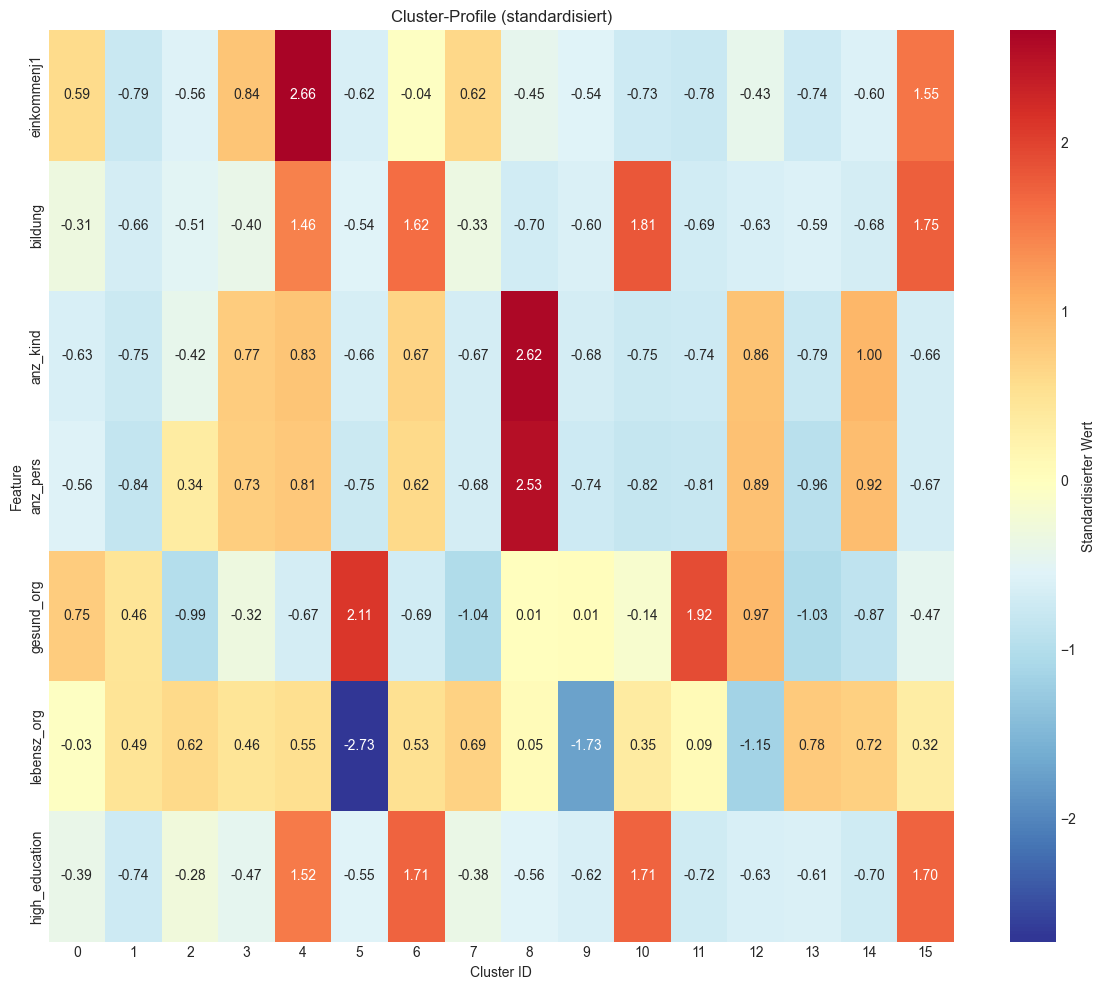

Heatmap gespeichert


In [14]:
# Erstelle Heatmap
fig = mapper.visualize_cluster_profiles()

# Speichere
fig.savefig('../data/processed/cluster_profiles_heatmap.png', dpi=300, bbox_inches='tight')

# Zeige
plt.show()

# Info
print("Heatmap gespeichert")

---
## 6. INKAR-Daten (2015-2019)

### Datenquelle
**INKAR** - Bundesinstitut für Bau-, Stadt- und Raumforschung (BBSR)

### Verfügbare Indikatoren
| Indikator | Jahre | Beschreibung |
|-----------|-------|-------------|
| arbeitslosenquote | 2015-2019 | Arbeitslosenquote (%) |
| schulabg_ohne_abschluss | 2015-2019 | Schulabgänger ohne Abschluss (%) |
| abiturquote | 2015-2019 | Abiturquote (%) |
| kinderarmut | **2016-2019** | Kinderarmut (%) - **2015 = NaN** |
| betreuungsquote | 2015-2019 | Betreuungsquote Vorschulkinder (%) |
| medianeinkommen | 2015-2019 | Medianeinkommen (Euro/Monat) |

In [15]:
# Lade INKAR-Daten im Long-Format
inkar_long = create_inkar_long_format()

# Zeige Info
print(f'INKAR Long-Format: {inkar_long.shape}')
print(f'  - 16 Bundesländer × 5 Jahre = 80 Zeilen')
print(f'\nSpalten: {inkar_long.columns.tolist()}')

# Zeige Beispiel: Bayern alle Jahre
print('\nBeispiel - Bayern:')
inkar_long[inkar_long['bundesland'] == 'Bayern']

INKAR Long-Format: (80, 8)
  - 16 Bundesländer × 5 Jahre = 80 Zeilen

Spalten: ['bundesland', 'year', 'arbeitslosenquote', 'schulabg_ohne_abschluss', 'abiturquote', 'betreuungsquote', 'medianeinkommen', 'kinderarmut']

Beispiel - Bayern:


,bundesland,year,arbeitslosenquote,schulabg_ohne_abschluss,abiturquote,betreuungsquote,medianeinkommen,kinderarmut
40,Bayern,2015,3.62,5.02,27.07,90.20,3323.93,NaN
41,Bayern,2016,3.47,5.11,40.66,90.12,3375.07,6.54
42,Bayern,2017,3.18,5.26,28.80,89.79,3459.81,6.94
43,Bayern,2018,2.87,5.32,28.48,89.51,3571.39,6.62
44,Bayern,2019,2.84,5.42,28.71,89.46,3676.05,6.14


In [16]:
# Prüfe Kinderarmut NaN für 2015
nan_2015 = inkar_long[inkar_long['year'] == 2015]['kinderarmut'].isna().sum()
print(f'Kinderarmut 2015: {nan_2015}/16 NaN (erwartet: alle)')

# Prüfe Kinderarmut für 2016-2019
nan_other = inkar_long[inkar_long['year'] > 2015]['kinderarmut'].isna().sum()
print(f'Kinderarmut 2016-2019: {nan_other} NaN (erwartet: 0)')

Kinderarmut 2015: 16/16 NaN (erwartet: alle)
Kinderarmut 2016-2019: 0 NaN (erwartet: 0)


---
## 7. Cluster-Bundesland Matching

### Strategie

1. **Durchschnittswerte berechnen** (2015-2019) für stabiles Matching
2. **Normalisieren** (z-Score) für Vergleichbarkeit
3. **Euklidische Distanz** zwischen Clustern und Bundesländern
4. **Hungarian Algorithm** für optimale 1:1 Zuordnung

### Feature-Mapping
| SOEP | INKAR |
|------|-------|
| einkommenj1 | medianeinkommen |
| bildung | abiturquote |

In [17]:
# Führe Matching durch
matching = match_clusters_to_bundeslaender(
    cluster_profiles=cluster_profiles,
    cluster_features=['einkommenj1', 'bildung'],
    inkar_features=['medianeinkommen', 'abiturquote']
)

# Drucke Report
print_matching_report(matching)

CLUSTER-BUNDESLAND MATCHING REPORT

--- Zuordnungen (sortiert nach Qualität) ---

Cluster  0 -> Bremen                    | Distanz: 0.24 | SEHR_GUT
Cluster  3 -> Hessen                    | Distanz: 0.31 | SEHR_GUT
Cluster  6 -> Berlin                    | Distanz: 0.37 | SEHR_GUT
Cluster  1 -> Sachsen                   | Distanz: 0.45 | SEHR_GUT
Cluster 11 -> Thüringen                 | Distanz: 0.59 | GUT
Cluster  7 -> Baden-Württemberg         | Distanz: 0.68 | GUT
Cluster  9 -> Niedersachsen             | Distanz: 0.75 | GUT
Cluster 13 -> Mecklenburg-Vorpommern    | Distanz: 0.75 | GUT
Cluster  5 -> Schleswig-Holstein        | Distanz: 0.87 | GUT
Cluster 14 -> Sachsen-Anhalt            | Distanz: 0.88 | GUT
Cluster 12 -> Saarland                  | Distanz: 0.90 | GUT
Cluster  2 -> Rheinland-Pfalz           | Distanz: 1.02 | MITTEL
Cluster 15 -> Hamburg                   | Distanz: 1.25 | MITTEL
Cluster  8 -> Bayern                    | Distanz: 1.33 | MITTEL
Cluster 10 -> Branden

---
## 8. Qualitätskontrolle

### Match-Qualität
| Qualität | Distanz | Bedeutung |
|----------|---------|----------|
| SEHR_GUT | < 0.5 | Sehr ähnliche Profile |
| GUT | 0.5 - 1.0 | Ähnliche Profile |
| MITTEL | 1.0 - 1.5 | Akzeptabel |
| SCHWACH | > 1.5 | Unterschiedlich |

### Bestanden-Kriterium
**>= 50% der Matches sind GUT oder SEHR_GUT**

In [18]:
# Hole Qualitäts-Statistiken
quality = matching['quality']

# Zeige detailliert
print('QUALITÄTSKONTROLLE')
print('=' * 50)
print(f"\nSEHR_GUT: {quality['counts']['SEHR_GUT']} ({quality['percentages']['SEHR_GUT']}%)")
print(f"GUT:      {quality['counts']['GUT']} ({quality['percentages']['GUT']}%)")
print(f"MITTEL:   {quality['counts']['MITTEL']} ({quality['percentages']['MITTEL']}%)")
print(f"SCHWACH:  {quality['counts']['SCHWACH']} ({quality['percentages']['SCHWACH']}%)")
print(f"\nDurchschnittsdistanz: {quality['mean_distance']}")

# Gesamtbewertung
good = quality['counts']['SEHR_GUT'] + quality['counts']['GUT']
print(f"\nGesamtbewertung: {good}/16 = {good/16*100:.0f}% GUT oder besser")
if quality['passed']:
    print("-> BESTANDEN")
else:
    print("-> NICHT BESTANDEN")

QUALITÄTSKONTROLLE

SEHR_GUT: 4 (25.0%)
GUT:      7 (43.8%)
MITTEL:   3 (18.8%)
SCHWACH:  2 (12.5%)

Durchschnittsdistanz: 0.893

Gesamtbewertung: 11/16 = 69% GUT oder besser
-> BESTANDEN


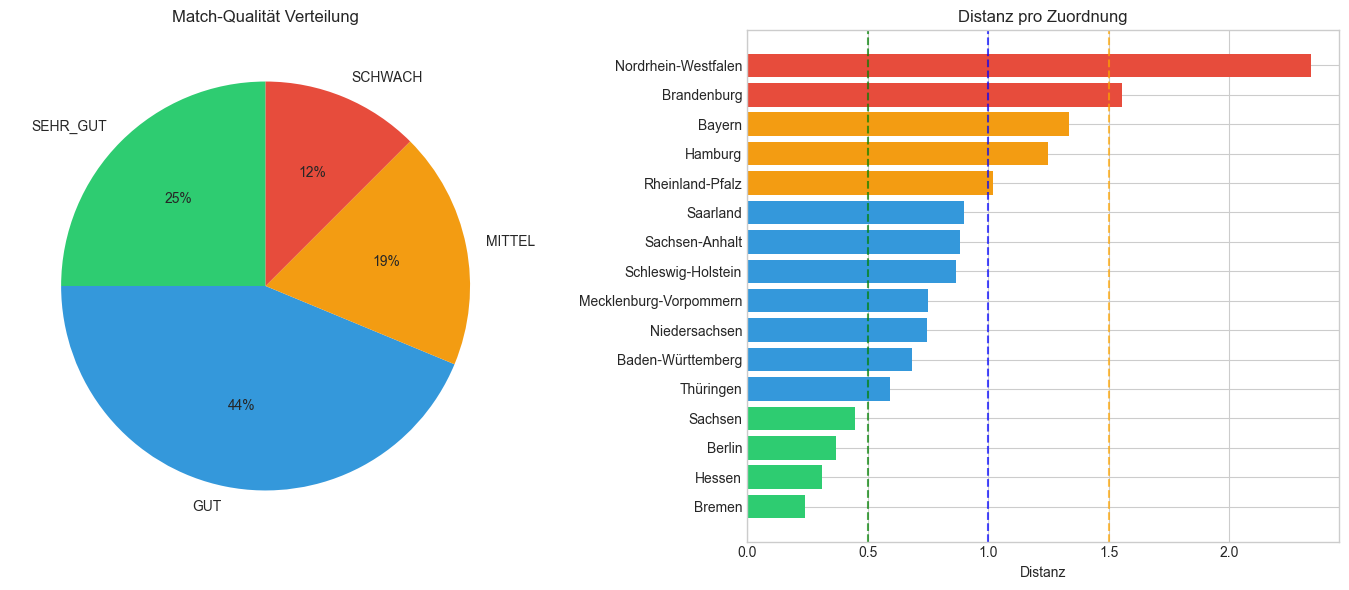

In [19]:
# Visualisiere Qualität
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Tortendiagramm ---
labels = ['SEHR_GUT', 'GUT', 'MITTEL', 'SCHWACH']
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
sizes = [quality['counts'][l] for l in labels]

# Zeichne Torte
axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', startangle=90)
axes[0].set_title('Match-Qualität Verteilung')

# --- Balkendiagramm ---
results_df = matching['results'].sort_values('distanz')
color_map = {'SEHR_GUT': '#2ecc71', 'GUT': '#3498db', 'MITTEL': '#f39c12', 'SCHWACH': '#e74c3c'}
bar_colors = [color_map[q] for q in results_df['quality']]

# Zeichne Balken
axes[1].barh(results_df['bundesland'], results_df['distanz'], color=bar_colors)

# Schwellenwerte
axes[1].axvline(x=0.5, color='green', linestyle='--', alpha=0.7)
axes[1].axvline(x=1.0, color='blue', linestyle='--', alpha=0.7)
axes[1].axvline(x=1.5, color='orange', linestyle='--', alpha=0.7)

# Labels
axes[1].set_xlabel('Distanz')
axes[1].set_title('Distanz pro Zuordnung')

# Layout
plt.tight_layout()
plt.savefig('../data/processed/matching_quality.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 9. Jahr-spezifischer Merge

### Wichtig
- SOEP hat Spalte `syear` (2015-2019)
- INKAR hat Werte für jedes Jahr (2015-2019)
- **Merge: syear = INKAR-Jahr**

### Beispiel
- Person mit `syear=2017` in Cluster 5 (→ Bayern)
- Bekommt Bayern-Werte von **2017**, nicht 2019!

In [20]:
# Zeige Mapping
print('Cluster -> Bundesland Mapping:')
for cluster_id, bundesland in sorted(matching['mapping'].items()):
    print(f'  Cluster {cluster_id:2d} -> {bundesland}')

Cluster -> Bundesland Mapping:
  Cluster  0 -> Bremen
  Cluster  1 -> Sachsen
  Cluster  2 -> Rheinland-Pfalz
  Cluster  3 -> Hessen
  Cluster  4 -> Nordrhein-Westfalen
  Cluster  5 -> Schleswig-Holstein
  Cluster  6 -> Berlin
  Cluster  7 -> Baden-Württemberg
  Cluster  8 -> Bayern
  Cluster  9 -> Niedersachsen
  Cluster 10 -> Brandenburg
  Cluster 11 -> Thüringen
  Cluster 12 -> Saarland
  Cluster 13 -> Mecklenburg-Vorpommern
  Cluster 14 -> Sachsen-Anhalt
  Cluster 15 -> Hamburg


In [21]:
# Führe Jahr-spezifischen Merge durch
print(f'Vorher: {df.shape}')

# Merge mit INKAR-Daten basierend auf Bundesland UND Jahr
df_final = merge_inkar_by_year(
    df=df,
    mapping=matching['mapping'],
    year_column='syear'
)

# Info
print(f'Nachher: {df_final.shape}')
print(f'\nNeue Spalten:')
new_cols = [c for c in df_final.columns if c not in df.columns]
for c in new_cols:
    print(f'  - {c}')

Vorher: (21753, 17)
Nachher: (21753, 24)

Neue Spalten:
  - matched_bundesland
  - arbeitslosenquote
  - schulabg_ohne_abschluss
  - abiturquote
  - betreuungsquote
  - medianeinkommen
  - kinderarmut


In [22]:
# Prüfe Kinderarmut NaN für 2015
nan_2015 = df_final[df_final['syear'] == 2015]['kinderarmut'].isna().sum()
total_2015 = len(df_final[df_final['syear'] == 2015])
print(f'Kinderarmut 2015: {nan_2015}/{total_2015} NaN')

# Prüfe Kinderarmut für 2016-2019
nan_other = df_final[df_final['syear'] > 2015]['kinderarmut'].isna().sum()
print(f'Kinderarmut 2016-2019: {nan_other} NaN')

Kinderarmut 2015: 5141/5141 NaN
Kinderarmut 2016-2019: 0 NaN


In [23]:
# Zeige Sample
sample_cols = [
    'syear',                 # SOEP: Jahr
    'bildung',               # SOEP: Bildung
    'einkommenj1',           # SOEP: Einkommen
    'region_cluster',        # Cluster-ID
    'matched_bundesland',    # Zugeordnetes Bundesland
    'arbeitslosenquote',     # INKAR: Jahr-spezifisch!
    'abiturquote',           # INKAR: Jahr-spezifisch!
    'kinderarmut'            # INKAR: Jahr-spezifisch (NaN für 2015)
]

# Filtere existierende Spalten
cols = [c for c in sample_cols if c in df_final.columns]

# Zeige Sample
print('Sample (verschiedene Jahre):')
df_final[cols].head(15)

Sample (verschiedene Jahre):


,syear,bildung,einkommenj1,region_cluster,matched_bundesland,arbeitslosenquote,abiturquote,kinderarmut
0,2015.0,10.5,28678.943359,0,Bremen,10.88,33.81,NaN
1,2016.0,10.5,19962.292969,9,Niedersachsen,5.97,37.97,14.47
2,2017.0,10.5,22227.675781,0,Bremen,10.17,36.25,31.74
3,2018.0,10.5,22100.378906,5,Schleswig-Holstein,5.48,35.38,15.60
4,2019.0,10.5,23157.919922,11,Thüringen,5.27,32.73,12.00
5,2015.0,10.0,0.000000,13,Mecklenburg-Vorpommern,10.41,29.60,NaN
6,2016.0,15.0,14430.264648,6,Berlin,9.78,45.19,28.20
7,2018.0,15.0,48435.136719,15,Hamburg,6.32,52.75,19.65
8,2019.0,15.0,53623.964844,15,Hamburg,6.13,53.87,18.98
9,2015.0,18.0,0.000000,10,Brandenburg,8.68,34.02,NaN


In [24]:
# Validierung: Jahr-spezifische Werte korrekt?
print('Validierung: Jahr-spezifische INKAR-Werte')
print('=' * 60)

# Wähle ein Bundesland
test_bl = list(matching['mapping'].values())[0]
test_cluster = list(matching['mapping'].keys())[0]

print(f'Teste: Cluster {test_cluster} -> {test_bl}\n')

# Vergleiche für jedes Jahr
for year in [2015, 2016, 2017, 2018, 2019]:
    # SOEP-Wert (aus finalem DataFrame)
    soep = df_final[(df_final['region_cluster'] == test_cluster) & (df_final['syear'] == year)]
    if len(soep) > 0:
        alq_soep = soep['arbeitslosenquote'].iloc[0]
        
        # INKAR-Original
        inkar = inkar_long[(inkar_long['bundesland'] == test_bl) & (inkar_long['year'] == year)]
        alq_inkar = inkar['arbeitslosenquote'].iloc[0]
        
        # Vergleiche
        match = "OK" if abs(alq_soep - alq_inkar) < 0.01 else "FEHLER"
        print(f'{year}: SOEP={alq_soep:.2f}%, INKAR={alq_inkar:.2f}% -> {match}')

Validierung: Jahr-spezifische INKAR-Werte
Teste: Cluster 0 -> Bremen

2015: SOEP=10.88%, INKAR=10.88% -> OK
2016: SOEP=10.46%, INKAR=10.46% -> OK
2017: SOEP=10.17%, INKAR=10.17% -> OK
2018: SOEP=10.00%, INKAR=10.00% -> OK
2019: SOEP=9.93%, INKAR=9.93% -> OK


---
## 10. Speichern

In [25]:
# Speichere finalen Datensatz
output_path = '../data/processed/soep_with_regions.csv'
df_final.to_csv(output_path, index=False)
print(f'Datensatz gespeichert: {output_path}')
print(f'  - Zeilen: {len(df_final)}')
print(f'  - Spalten: {len(df_final.columns)}')

# Speichere Cluster-Profile
cluster_profiles.to_csv('../data/processed/cluster_profiles.csv')
print('\nCluster-Profile gespeichert')

# Speichere Matching
matching['results'].to_csv('../data/processed/cluster_bundesland_matching.csv', index=False)
print('Matching-Ergebnisse gespeichert')

Datensatz gespeichert: ../data/processed/soep_with_regions.csv
  - Zeilen: 21753
  - Spalten: 24

Cluster-Profile gespeichert
Matching-Ergebnisse gespeichert


---
## 11. Zusammenfassung

### Erledigt
1. **Datenbereinigung:** String-Labels automatisch in Zahlen konvertiert
2. **K-Means:** 16 Cluster erstellt
3. **Hungarian Algorithm:** Optimale 1:1 Zuordnung
4. **Jahr-spezifischer Merge:** SOEP-Jahr = INKAR-Jahr
5. **Qualitätskontrolle:** Bestanden/Nicht bestanden

### Daten
- **INKAR-Jahre:** 2015-2019
- **Kinderarmut 2015:** NaN (nicht verfügbar)
- **Jahr-spezifisch:** Person mit syear=2017 bekommt INKAR-2017 Werte

### Limitationen
- Cluster sind synthetisch (nicht echte Regionen)
- Matching basiert auf 2 Features
- Kinderarmut fehlt für 2015